# Customer-churn prediction for an Iranian telecom

The rapid growth of the telecommunications industry has led to intense competition, making customer retention more important than ever. Predicting customer churn - when subscribers are likely to leave a service - has become a crucial task for telecom service providers seeking to maintain market share and sustain profitability. In this project, I apply data mining and machine learning techniques to a real-world dataset of Iranian telecom company to identify key drivers of subscriber churn and build predictive models that will enable the development of effective subscriber retention strategies. Through data exploration, feature development, model building and business-oriented modeling, this project aims to provide actionable recommendations to reduce customer churn and increase overall customer value.

### Research Questions

1. What are the main factors that influence customer churn in the telecom dataset?

2. How accurately can customer churn be predicted using classical machine learning models?

3. How does changing the intervention threshold affect the number of at-risk customers and potential revenue at risk?


Full code and figures: [github.com/intox1ca7ed/Churn-Prediction-Project](https://github.com/intox1ca7ed/Churn-Prediction-Project.git); this notebook generates all assets used in the accompanying 20-page report.


## Data Overview

This dataset is randomly collected from an [Iranian telecom company's database](https://archive.ics.uci.edu/dataset/563/iranian+churn+dataset) over a period of 12 months. A total of 3150 rows of data, each representing a customer, bear information for 13 columns.

Call Failures: number of call failures  
Complains: binary (0: No complaint, 1: complaint)  
Subscription Length: total months of subscription  
Charge Amount: Ordinal attribute (0: lowest amount, 9: highest amount)  
Seconds of Use: total seconds of calls  
Frequency of use: total number of calls  
Frequency of SMS: total number of text messages  
Distinct Called Numbers: total number of distinct phone calls   
Age Group: ordinal attribute (1: younger age, 5: older age)  
Tariff Plan: binary (1: Pay as you go, 2: contractual)  
Status: binary (1: active, 2: non-active)  
Churn: binary (1: churn, 0: non-churn) - Class label  
Customer Value: The calculated value of customer  

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, roc_auc_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.inspection import PartialDependenceDisplay
from collections import Counter
from sklearn.cluster import KMeans
import joblib
import shap

RANDOM_STATE = 44

# base directory & path to get rid of hard-pathing
import os
base_dir = os.getcwd()
dataset_path = os.path.join(base_dir, "customer-churn.csv")

## Data Audit & Cleaning
 Check dtypes, missing values, outliers

In [2]:
df = pd.read_csv(dataset_path)
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces
df.columns = df.columns.str.replace(' +', ' ', regex=True)  # Replace multiple spaces with single space

summary = pd.DataFrame({
    'dtype': df.dtypes,
    'num_missing': df.isnull().sum(),
    'num_unique': df.nunique()
})
display(summary)

print("\nDescriptive statistics:")
display(df.describe())

,dtype,num_missing,num_unique
Call Failure,int64,0,37
Complains,int64,0,2
Subscription Length,int64,0,45
Charge Amount,int64,0,11
Seconds of Use,int64,0,1756
Frequency of use,int64,0,242
Frequency of SMS,int64,0,405
Distinct Called Numbers,int64,0,92
Age Group,int64,0,5
Tariff Plan,int64,0,2



Descriptive statistics:


,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,1.077778,1.248254,30.998413,470.972916,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,517.015433,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,1.000000,25.000000,113.801250,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,1.000000,30.000000,228.480000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,1.000000,30.000000,788.388750,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,55.000000,2165.280000,1.000000


In [3]:
num_cols = df.select_dtypes(include=[np.number]).columns #outlier check

print("IQR approach:")
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    print(f"{col}: {outliers} outliers")

#  z score 
from scipy.stats import zscore
z_scores = np.abs(zscore(df[num_cols]))
outlier_counts = (z_scores > 3).sum(axis=0)
print("\nOutliers per column (when z score > 3):")
for col, count in zip(num_cols, outlier_counts):
    print(f"{col}: {count}")

IQR approach:
Call Failure: 47 outliers
Complains: 241 outliers
Subscription Length: 282 outliers
Charge Amount: 370 outliers
Seconds of Use: 200 outliers
Frequency of use: 129 outliers
Frequency of SMS: 368 outliers
Distinct Called Numbers: 77 outliers
Age Group: 170 outliers
Tariff Plan: 245 outliers
Status: 782 outliers
Age: 688 outliers
Customer Value: 116 outliers
Churn: 495 outliers

Outliers per column (when z score > 3):
Call Failure: 40
Complains: 241
Subscription Length: 26
Charge Amount: 65
Seconds of Use: 1
Frequency of use: 24
Frequency of SMS: 66
Distinct Called Numbers: 57
Age Group: 0
Tariff Plan: 245
Status: 0
Age: 0
Customer Value: 53
Churn: 0


## Feature Engineering
Tenure buckets, usage ratios, log-revenue, one-hot tariff

In [4]:
#creating bins for subscription length
tenure_bins = [0, 12, 24, 36, df['Subscription Length'].max()]
tenure_labels = ['<1y', '1-2y', '2-3y', '>3y']
df['Tenure_Bucket'] = pd.cut(df['Subscription Length'], bins=tenure_bins, labels=tenure_labels, right=True)

df['SMS_per_Call'] = df['Frequency of SMS'] / df['Frequency of use'].replace(0, np.nan)
df['Seconds_per_Call'] = df['Seconds of Use'] / df['Frequency of use'].replace(0, np.nan)

#Log revenue
df['Log_Charge_Amount'] = np.log1p(df['Charge Amount'])

#one-hot tariff plan
tariff_cols = [col for col in df.columns if col.startswith("Tariff_")] #to handle duplication of tariff column
df = df.drop(columns=tariff_cols, errors='ignore')
tariff_dummies = pd.get_dummies(df['Tariff Plan'], prefix='Tariff')
df = pd.concat([df, tariff_dummies], axis=1)
df[['SMS_per_Call', 'Seconds_per_Call']] = df[['SMS_per_Call', 'Seconds_per_Call']].fillna(0)

display(df[['Tenure_Bucket', 'SMS_per_Call', 'Seconds_per_Call', 'Log_Charge_Amount'] + list(tariff_dummies.columns)].tail(10))

,Tenure_Bucket,SMS_per_Call,Seconds_per_Call,Log_Charge_Amount,Tariff_1,Tariff_2
3140,2-3y,0.548387,32.419355,0.000000,True,False
3141,2-3y,1.750000,70.625000,0.000000,True,False
3142,2-3y,0.684211,40.263158,0.693147,True,False
3143,2-3y,0.223881,52.686567,0.693147,True,False
3144,1-2y,1.093750,62.500000,0.693147,True,False
3145,1-2y,0.625850,45.557823,1.098612,False,True
3146,1-2y,0.451977,52.186441,0.693147,True,False
3147,1-2y,0.745098,61.901961,1.609438,True,False
3148,<1y,4.826087,102.065217,1.098612,True,False
3149,<1y,0.280000,71.680000,1.098612,True,False


## Exploratory Data Analysis (EDA)
Distributions, boxplots, churn comparisons, correlations

### Distribution plots

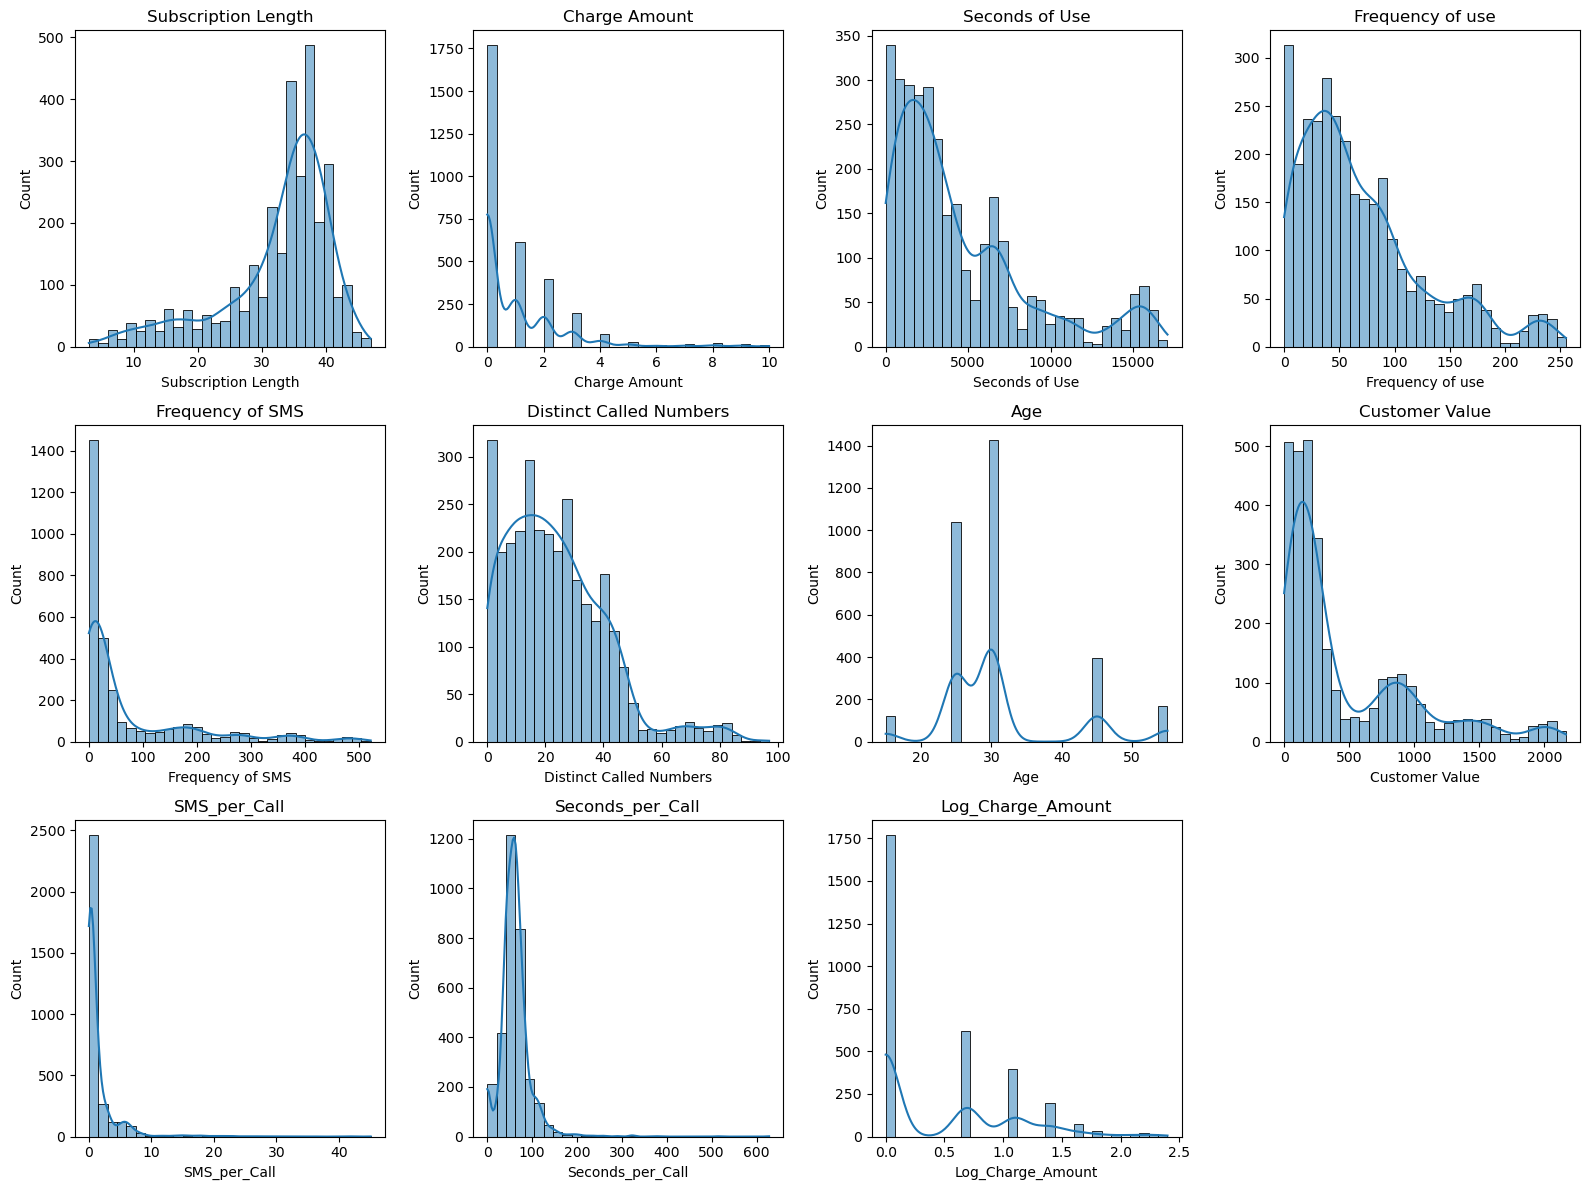

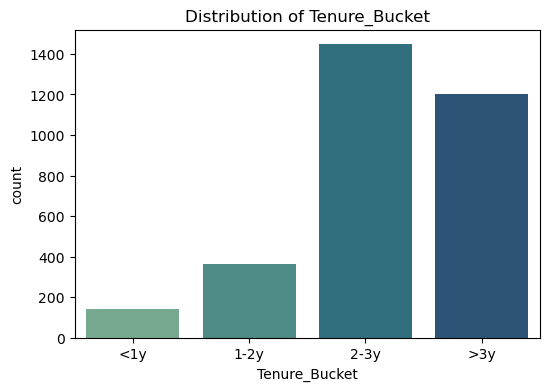

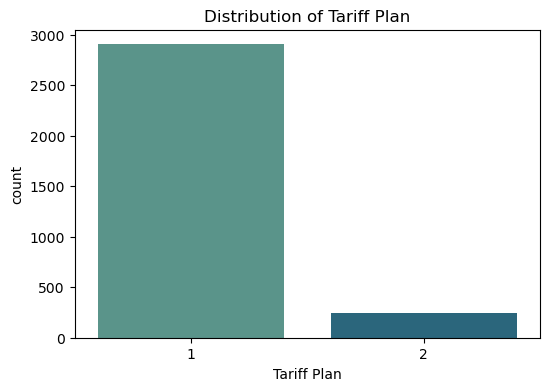

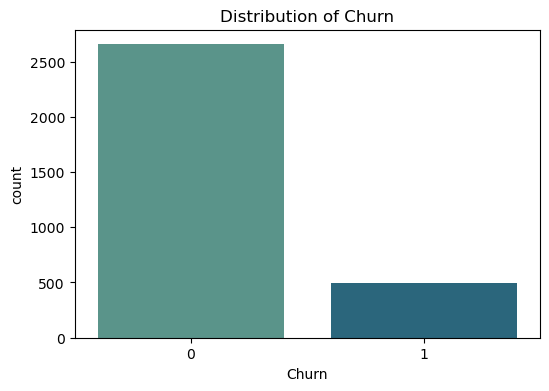

In [5]:
num_features = [
    'Subscription Length', 'Charge Amount', 'Seconds of Use', 'Frequency of use',
    'Frequency of SMS', 'Distinct Called Numbers', 'Age', 'Customer Value',
    'SMS_per_Call', 'Seconds_per_Call', 'Log_Charge_Amount'
]

plt.figure(figsize=(16, 12)) #numer
for i, col in enumerate(num_features):
    plt.subplot(3, 4, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

# categor
cat_features = ['Tenure_Bucket', 'Tariff Plan', 'Churn']
for col in cat_features:
    n_unique = df[col].nunique()
    palette = sns.color_palette("crest", n_colors=n_unique)
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df, palette=palette, hue=col, legend=False)
    plt.title(f"Distribution of {col}")
    plt.show()

Many features are right-skewed (as is typical for usage, revenue, customer value).  
Churn is imbalanced (majority non-churn, but not extreme).  
Most customers have 2–3 years tenure; Tariff 1 is dominant.  

### Boxplots Split by Churn

Allows us to see how key numerical features differ between churners and non-churners.

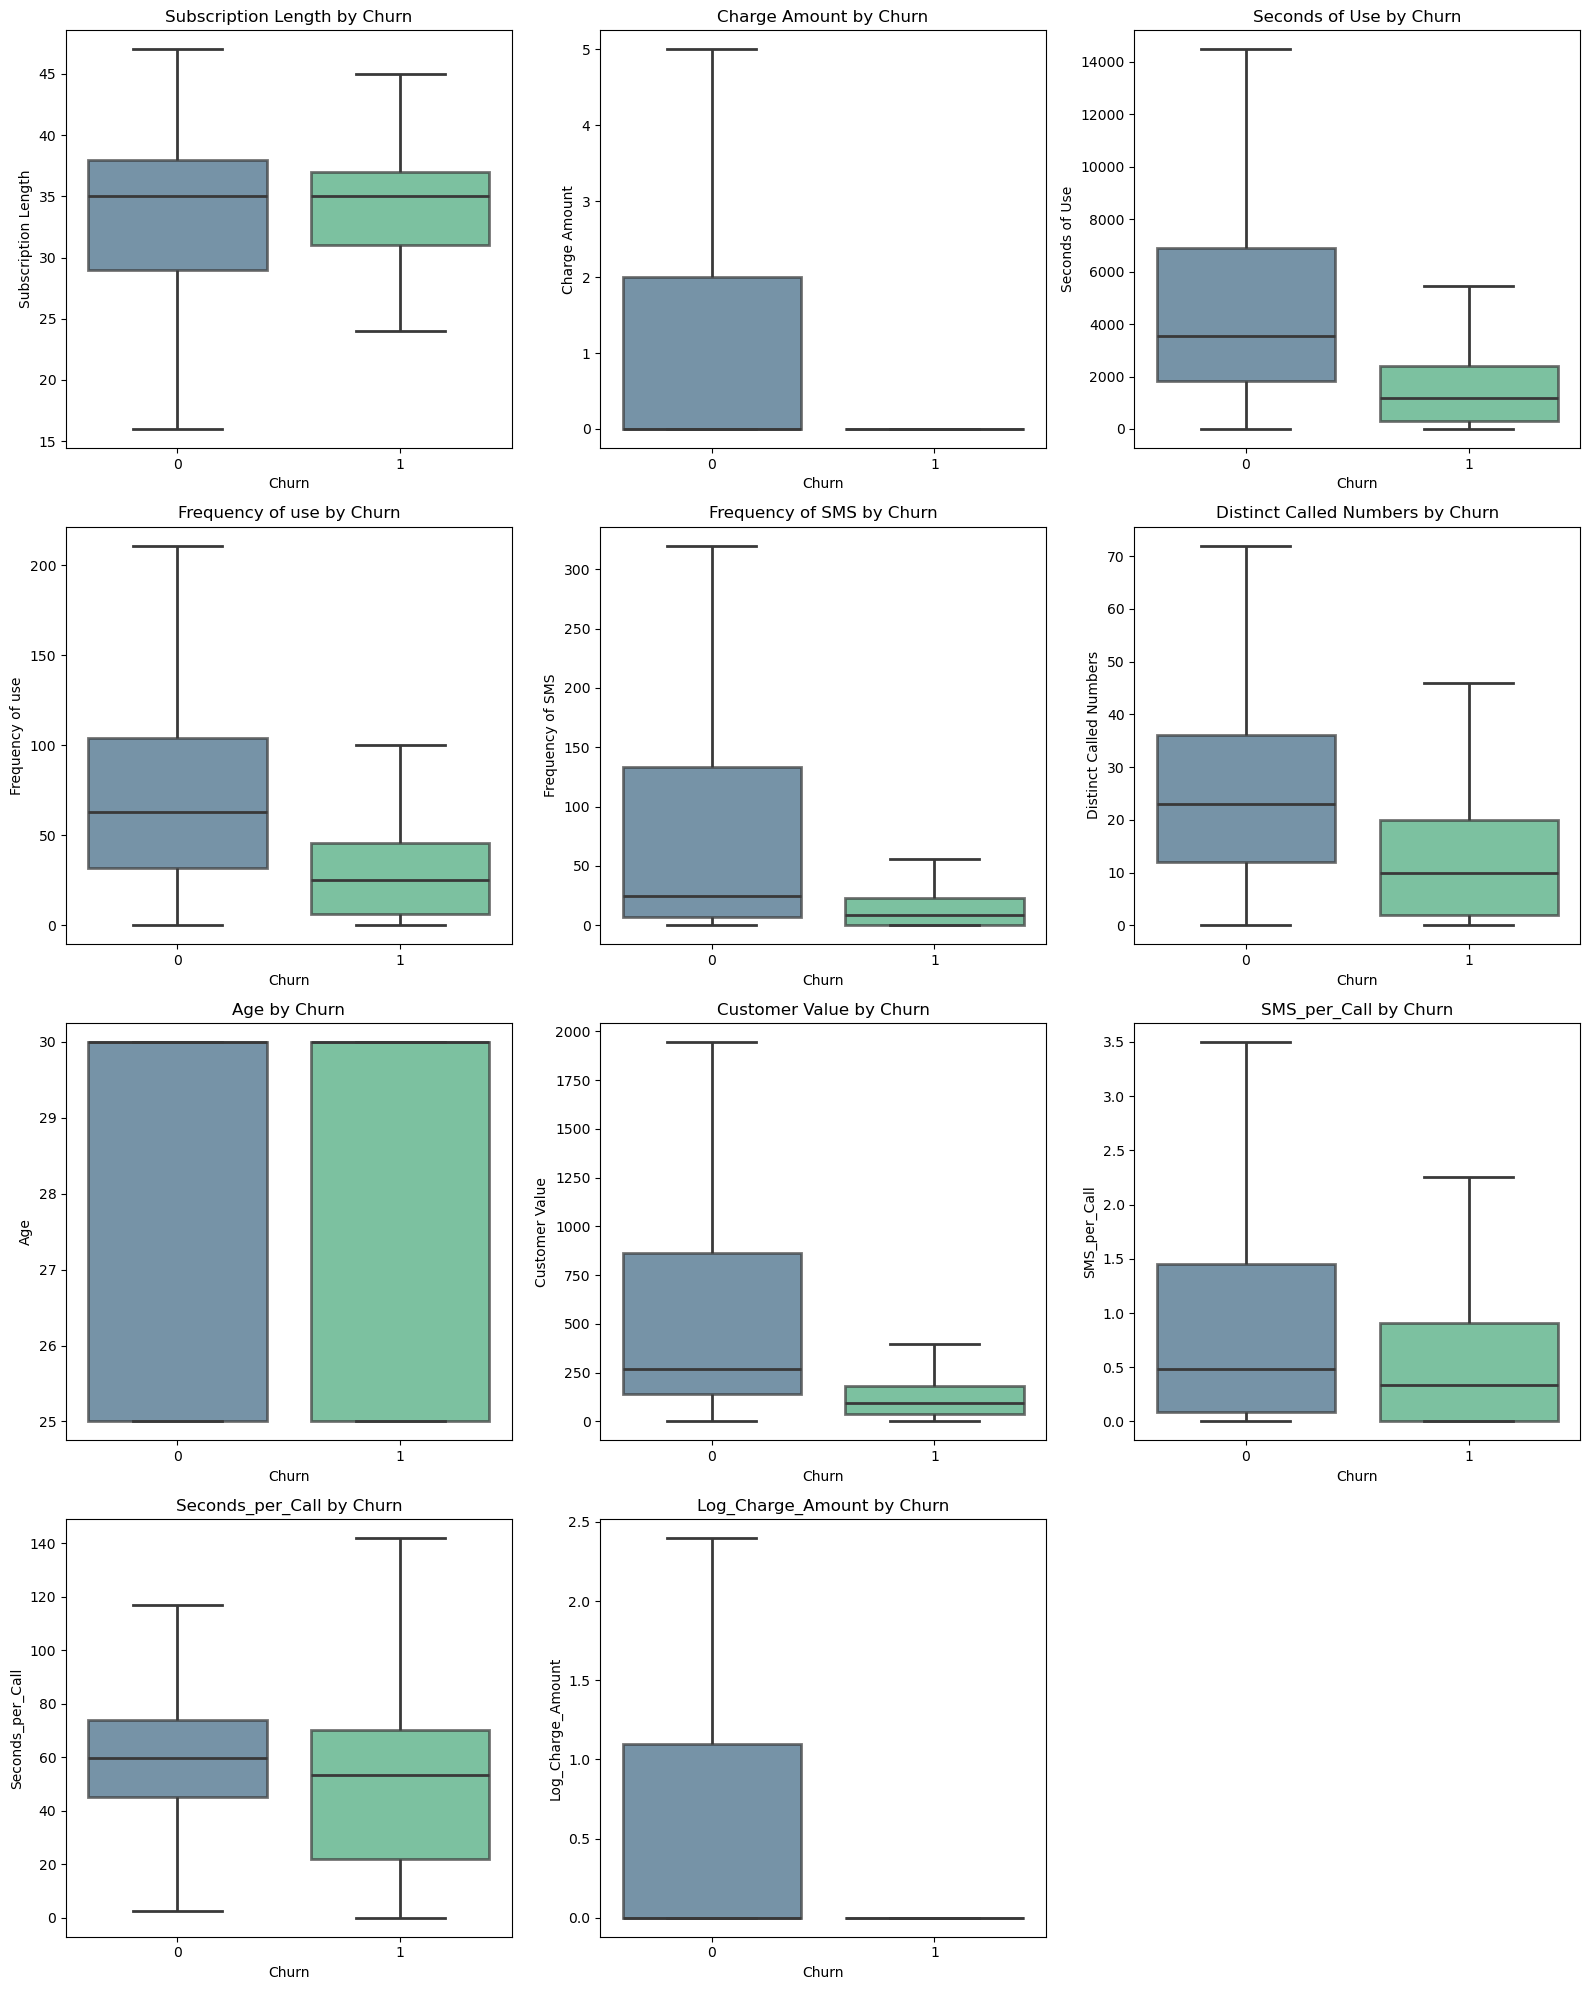

In [6]:
boxplot_features = [
    'Subscription Length', 'Charge Amount', 'Seconds of Use', 'Frequency of use',
    'Frequency of SMS', 'Distinct Called Numbers', 'Age', 'Customer Value',
    'SMS_per_Call', 'Seconds_per_Call', 'Log_Charge_Amount'
]

plt.figure(figsize=(16, 20))
for i, col in enumerate(boxplot_features):
    plt.subplot(4, 3, i+1)
    sns.boxplot(
    x='Churn',
    y=col,
    data=df,
    hue='Churn',
    showfliers=False,
    palette='viridis',
    linewidth=2,
    boxprops=dict(alpha=.7),
    legend=False
)
    plt.title(f'{col} by Churn')
plt.tight_layout()
plt.show()


- Most *usage* and *revenue* features (e.g. Charge Amount, Seconds of Use, Frequency of use/SMS...) show a clear drop in both median and spread for churners. That means churners tend to be low-usage, low-revenue, low-value customers.
- Age - almost identical for both churn and non-churn.
- Subscription Length - slight shift. Churners may have slightly shorter tenure, but there is overlap.

### Churn Group Comparisons

Here I want to numerically compare feature averages between churners and non-churners.

In [7]:
features_to_compare = [
    'Subscription Length', 'Charge Amount', 'Seconds of Use', 'Frequency of use',
    'Frequency of SMS', 'Distinct Called Numbers', 'Age', 'Customer Value',
    'SMS_per_Call', 'Seconds_per_Call', 'Log_Charge_Amount'
]

grouped = df.groupby('Churn')[features_to_compare].agg(['mean', 'median']).T
display(grouped)

Churn                                     0            1
Subscription Length     mean      32.662524    31.894949
                        median    35.000000    35.000000
Charge Amount           mean       1.075706     0.230303
                        median     0.000000     0.000000
Seconds of Use          mean    5014.224105  1566.632323
                        median  3530.000000  1182.000000
Frequency of use        mean      76.979284    29.133333
                        median    63.000000    25.000000
Frequency of SMS        mean      83.871563    15.802020
                        median    25.000000     9.000000
Distinct Called Numbers mean      25.582674    12.391919
                        median    23.000000    10.000000
Age                     mean      31.065913    30.636364
                        median    30.000000    30.000000
Customer Value          mean     535.511501   124.811414
                        median   268.070000    96.840000
SMS_per_Call            mean       1.683952     0.647678
                        median     0.483516     0.340426
Seconds_per_Call        mean      63.386805    53.908123
                        median    59.714286    53.468085
Log_Charge_Amount       mean       0.522962     0.134115
                        median     0.000000     0.000000

Overall, churned customers consistently show lower averages across usage and revenue metrics (such as charge amount, seconds of use, and customer value) compared to active customers. 

This highlights that low engagement and low revenue are strong signals for churn in this dataset.


### Correlation heatmap

In this section I will identify which numeric features are strongly correlated.

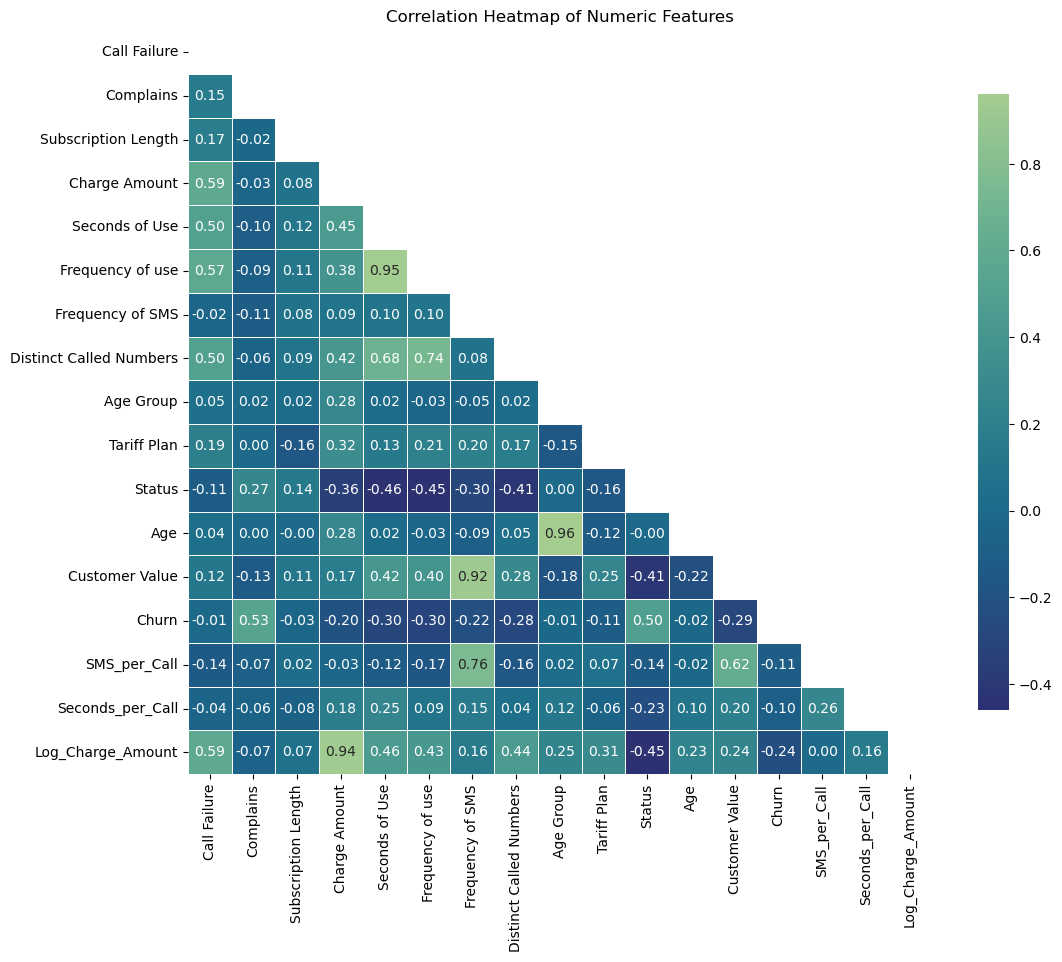

In [8]:
corr = df.select_dtypes(include=[np.number]).corr() #corr matrix

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.color_palette("crest_r", as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    annot=True,
    fmt=".2f",
    linewidths=.5,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

**Very Strong Positive Correlations:**

Frequency of use & Seconds of Use: `0.95`  
*Higher frequency leads to more seconds used (these are closely related usage features).*  
Customer Value & Frequency of SMS: `0.92`  
*In this dataset, customers who send a lot of SMS also have a higher overall value. Could reflect business-specific plans.*

**Moderate Negative Correlations with** `Status`:  
Frequency of use: `-0.45`  
Seconds of Use: `-0.46`  
Distinct Called Numbers: `-0.41`  
Customer Value: `-0.41`  
Charge Amount: `-0.36`  

*Negative correlation with usage/value metrics shows: non-active customers use the service less, have less value, and are less engaged. This is logical*


## Segmentation

This section is dedicated to segment the customer base into clusters based on standardized numeric features.

Then I will visualize them in 2D with PCA and profile clusters.

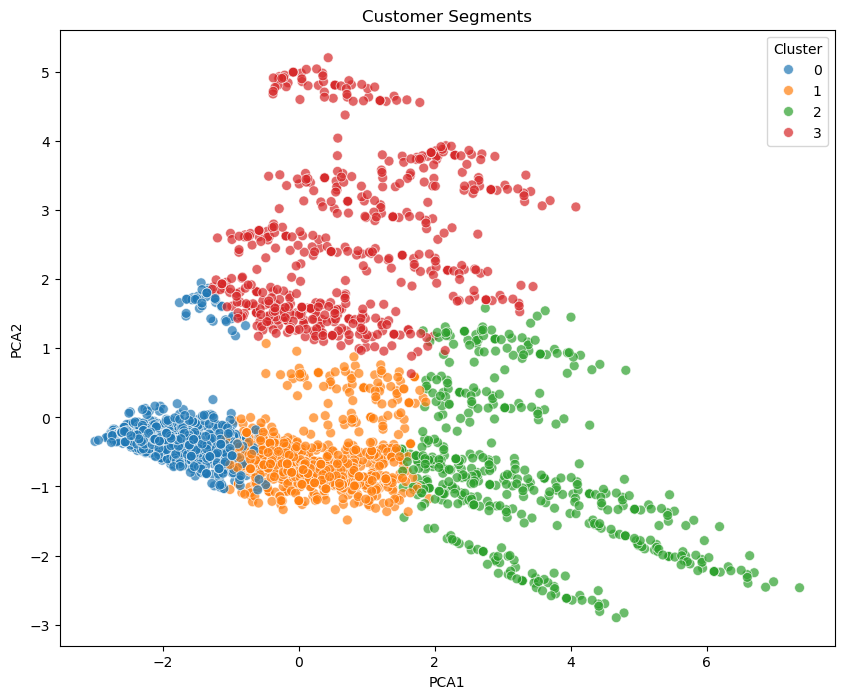

,Call Failure,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Customer Value,Churn
Cluster,,,,,,,,,
0,3.036207,30.325862,0.262931,1384.850000,23.523276,15.365517,9.300000,116.813332,0.275862
1,9.667345,33.890132,0.780264,4335.339776,76.618515,30.594100,29.768057,290.293286,0.173957
2,16.804979,34.369295,2.711618,12368.371369,168.093361,62.327801,45.699170,716.531919,0.000000
3,5.529524,33.236190,1.125714,4302.148571,67.003810,290.592381,22.817143,1366.351495,0.007619


In [9]:
# i exclude target, id and non-numeric categoricals
cluster_features = [
    'Call Failure', 'Subscription Length', 'Charge Amount', 'Seconds of Use',
    'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers',
    'Customer Value'
]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cluster_features])

#cluster
kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

pca = PCA(n_components=2, random_state=RANDOM_STATE) #reduce to 2 dimenstion
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10,8))
palette = sns.color_palette("tab10", n_colors=4)
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette=palette, s=50, alpha=0.7)
plt.title('Customer Segments')
plt.legend(title='Cluster')
plt.show()

cluster_profile = df.groupby('Cluster')[cluster_features + ['Churn']].mean()
display(cluster_profile)

- **Cluster 0 (blue):**  
Low usage, low value, highest churn (28%).  
Represents “at risk” or disengaged customers.  

- **Cluster 1 (orange):**  
Moderate usage, moderate value, 17% churn.  
Average and slightly engaged customers.  

- **Cluster 2 (green):**  
High usage, high value, 0% churn.  
Most loyal and highest-value segment customers.  

- **Cluster 3 (red):**  
Moderate-high call use, very high SMS usage, highest customer value, less than 1% churn.  
Likely a specific business customer group or people using SMS for mass messaging.  
  
  
  
**Key Takeaways**  
Highest churn is in low-usage, low-value cluster (Blue cluster 0).  

Power users and high SMS customers (Clusters 2 & 3) are the most loyal.  

## Class-Imbalance Handling

As we have discovered from the distribution plots previously, our data has class imbalance insofar as the target variable `Churn` has many more examples of *non-churn* than *churn*.  
This may lead models predict more often *non-churn* and miss actual churners who are important business-wise.  

Thus, I am going to set model options like `class_weight="balanced"` so that the model pays more attention to the minority class (*churn* in this case).   

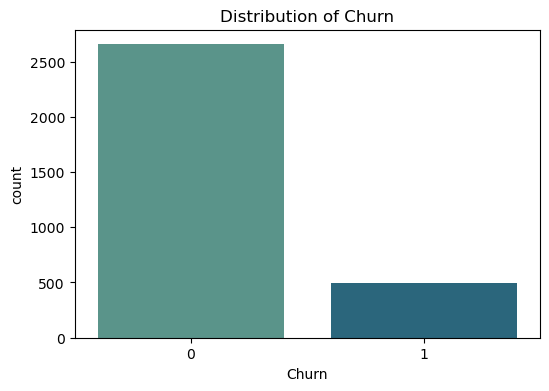


Distribution of "Churn": Counter({0: 2655, 1: 495})


In [10]:
# lets look at class distribution again
cat_features = ['Churn']
for col in cat_features:
    n_unique = df[col].nunique()
    palette = sns.color_palette("crest", n_colors=n_unique)
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df, palette=palette, hue=col, legend=False)
    plt.title(f"Distribution of {col}")
    plt.show()
print("\nDistribution of \"Churn\":", Counter(df['Churn']))

## Predictive Modelling

This section is dedicated to train and evaluate 2 models:
- Logistic Regression
- Random Forest

Furthermore, a stratified 5-fold cross validation will be applied and I report:
- ROC-AUC
- F1-scores
- Confusion matrix



In [11]:
features = [
    'Call Failure', 'Complains', 'Subscription Length', 'Charge Amount', 'Seconds of Use',
    'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Age Group',
    'Tariff Plan', 'Status', 'Customer Value',
    'Tenure_Bucket', 'SMS_per_Call', 'Seconds_per_Call', 'Log_Charge_Amount',
]

X = pd.get_dummies(df[features], drop_first=True)
y = df['Churn']

# 5-fold stratified cross-valid
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

### Logistic Regression (baseline)

In [12]:
# I got convergence warning the 1st time because ibfgs failed to converge with max_iter=1000
# so i had to scale the features first using StandardScaler()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

logreg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=44)
logreg_auc = cross_val_score(logreg, X_scaled, y, cv=cv, scoring="roc_auc").mean()
logreg_f1 = cross_val_score(logreg, X_scaled, y, cv=cv, scoring="f1").mean()
print(f"LogReg: mean ROC-AUC = {logreg_auc:.3f}, Mean F1 = {logreg_f1:.3f}")

LogReg: mean ROC-AUC = 0.942, Mean F1 = 0.669


The logistic regression model achieved a mean ROC-AUC of **0.942** and a mean F1-score of **0.669** in stratified cross-validation. This result indicates that the model can distinguish churners from non-churners with high probability.

- **0.942** ROC-AUC demonstrates strong ranking capability.
- **0.669** F1-score is moderate. It reflects a decent balance between both precision and recall for *non-churn*.


### Random Forest

In [13]:
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=RANDOM_STATE)
rf_auc = cross_val_score(rf, X, y, cv=cv, scoring="roc_auc").mean()
rf_f1 = cross_val_score(rf, X, y, cv=cv, scoring="f1").mean()
print(f"Random Forest: Mean ROC-AUC = {rf_auc:.3f}, Mean F1 = {rf_f1:.3f}")

rf_pred = cross_val_predict(rf, X, y, cv=cv) #matrix
print("Classification Report:")
print(classification_report(y, rf_pred))

rf_probs = cross_val_predict(rf, X, y, cv=cv, method="predict_proba")[:, 1] #precision-recall Auc
pr_auc = average_precision_score(y, rf_probs)
print(f"Random Forest PR-AUC: {pr_auc:.3f}")

Random Forest: Mean ROC-AUC = 0.985, Mean F1 = 0.860
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2655
           1       0.89      0.83      0.86       495

    accuracy                           0.96      3150
   macro avg       0.93      0.91      0.92      3150
weighted avg       0.96      0.96      0.96      3150

Random Forest PR-AUC: 0.922


Random Forest demonstrates even higher predictive performance with a mean ROC-AUC of **0.985** and F1-score of **0.860**.   
From the confusion matrix and classification report we can see that the model maintains high precision = **0.89** and recall = **0.83** for the *churn*. This results in an overall accuracy of **96%**.

Furthermore, precision-recall AUC is **0.922** which also tells us that the model is actually effective in identifying churners taking into account the aforementioned class-imbalance.

With regards to business interpretation - the random forest can be hypothetically launched into the production. It is able to exceedingly well identify churners with high accuracy and reliability.

Recall is **0.83** = low risk of missing most churners.

## Model Interpretation
  

  

### Random Forest Feature Importances

In this section I aim to identify which features are most influential for churn prediction according to the trained random forest model.

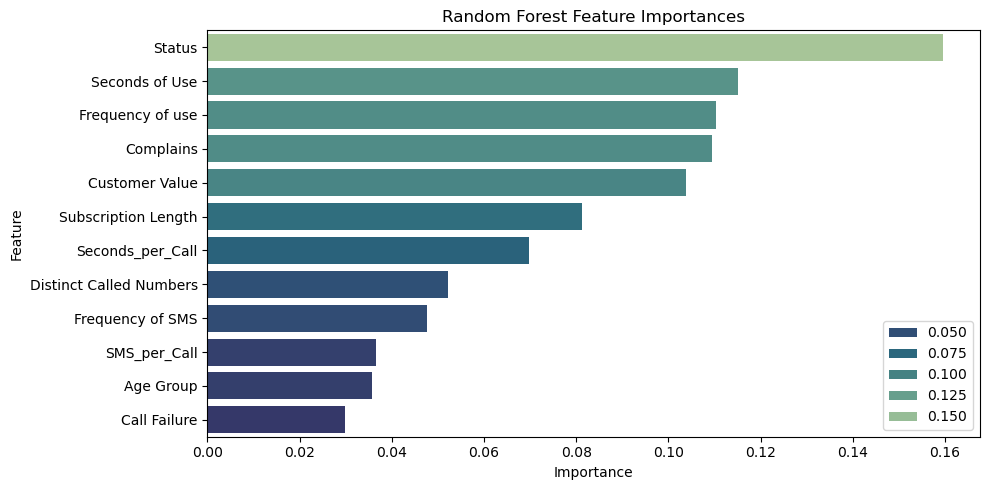

In [14]:
# RF on all data
rf_full = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=44)
rf_full.fit(X, y)

importances = rf_full.feature_importances_
feature_names = X.columns

indices = np.argsort(importances)[::-1]
top_n = 12

plt.figure(figsize=(10, 5))
sns.barplot(
    x=importances[indices][:top_n],
    y=np.array(feature_names)[indices][:top_n],
    palette="crest_r",
    hue=importances[indices][:top_n]
)
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

From the barplot it can be noticed that `Status` feature stands out as the single most influential predictor, followed by `Seconds of Use`, `Frequency of use`, `Complains` and etc. These results suggest that customer status, engagement with the service, and complaint history play the largest roles in identifying potential churners.

### Partial Dependence Plots

We want to see how the predicted probability of churn changes as a single feature varies, keeping other features averaged out.  

I have selected 3 numerical features for this purpose: `Seconds of Use`, `Frequency of use` and `Subscription Length`.   Unfortunately, it was not feasible to draw out categorical features due to technical and knowledge constrains.

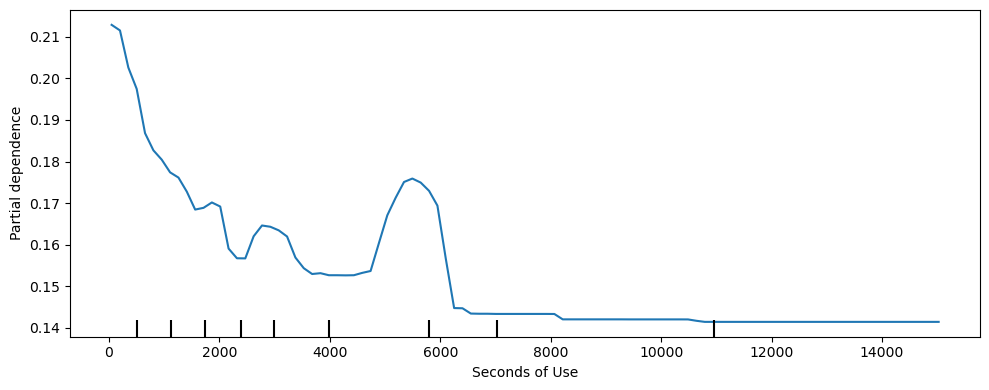

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
PartialDependenceDisplay.from_estimator(rf_full, X, features=['Seconds of Use'], ax=ax)
plt.tight_layout()
plt.show()

Churn probability is highest for users with very low call activity. As the total seconds of use increase, the risk of churn steadily drops, then spikes again at 5000 to 6000 seconds for high-usage customers.
Heavy users are much less likely to churn.

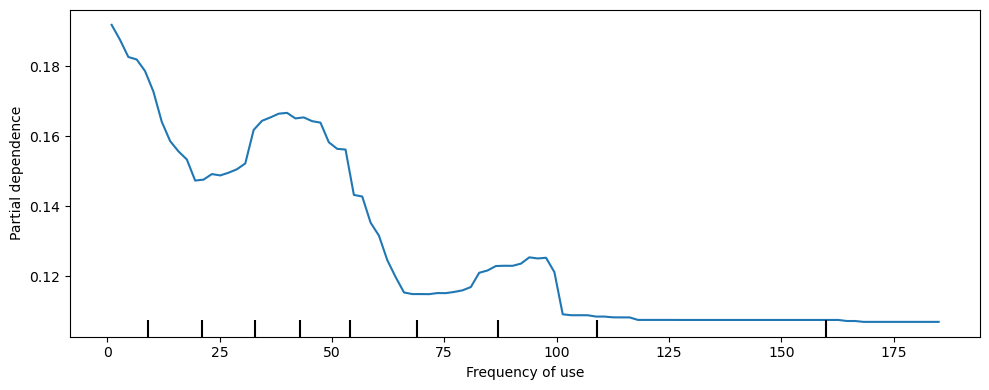

In [16]:
fig, ax = plt.subplots(figsize=(10, 4))
PartialDependenceDisplay.from_estimator(rf_full, X, features=['Frequency of use'], ax=ax)
plt.tight_layout()
plt.show()

Customers who make more frequent calls are less likely to churn. The risk decreases sharply up to about 100 calls, after which further increases have little additional effect.
Frequent callers are more loyal.

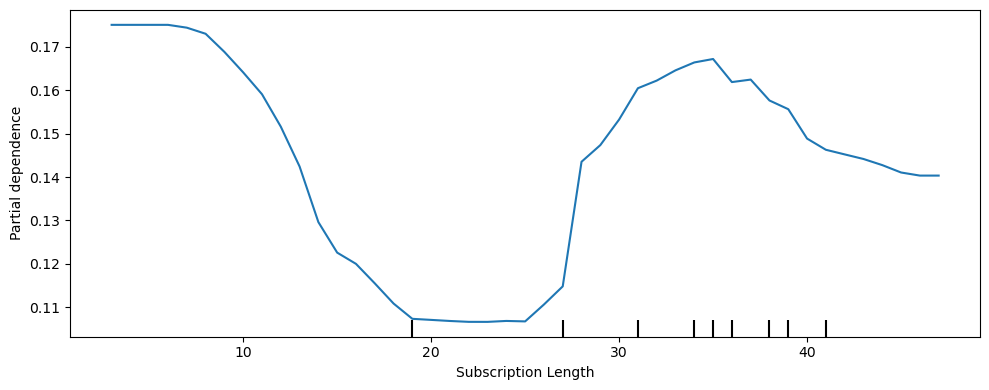

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))
PartialDependenceDisplay.from_estimator(rf_full, X, features=['Subscription Length'], ax=ax)
plt.tight_layout()
plt.show()

Churn risk declines with longer subscription length, reaching a low point around 10–26 months. After this, churn risk can rise again slightly for very long-tenured customers.
Newer subscribers are at higher risk, while mid-tenure customers are the most stable.

### SHAP

WIth the help of **SHAP** (SHapley Additive exPlanations) on the other hand, we can see wow each feature influences individual predictions across the whole dataset, with both the strength and direction of impact.

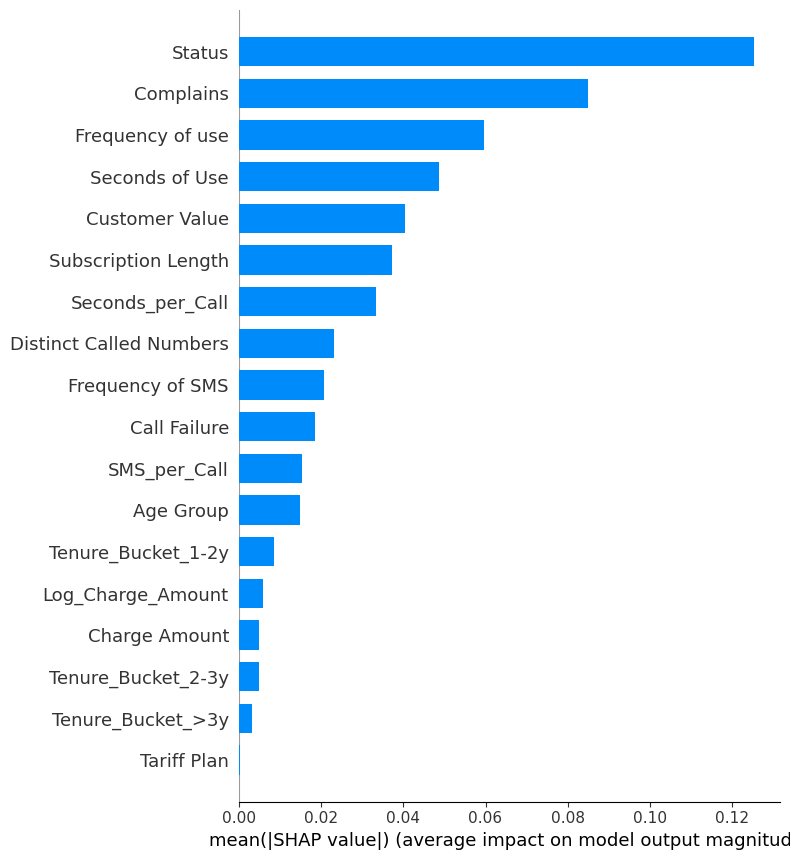

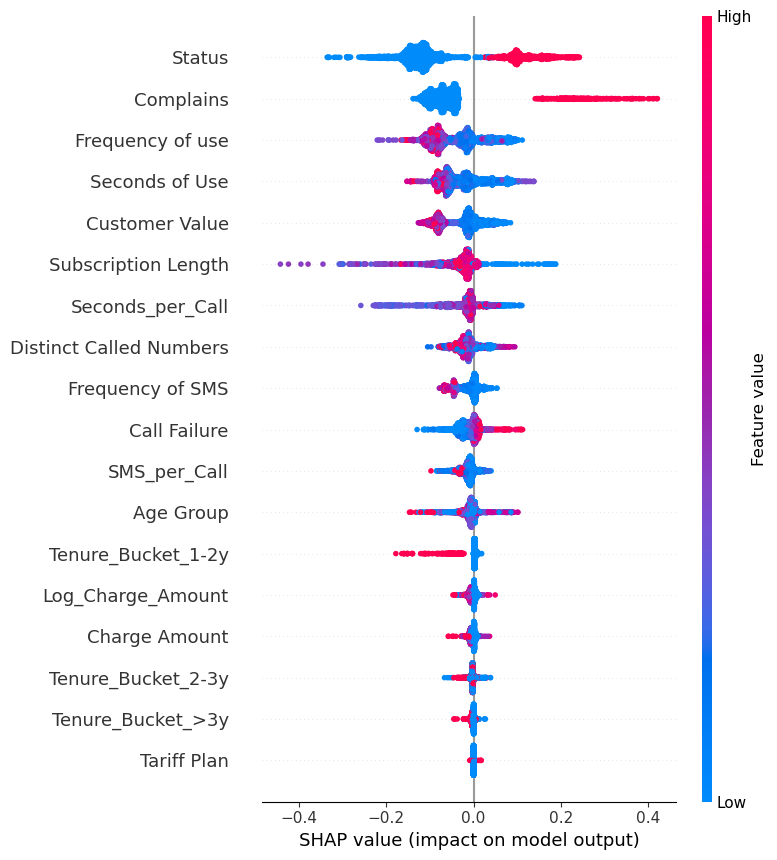

In [18]:
explainer = shap.TreeExplainer(rf_full)
shap_values = explainer.shap_values(X)

if len(shap_values.shape) == 3 and shap_values.shape[2] == 2:
    shap_values_for_class1 = shap_values[:, :, 1]
    shap.summary_plot(shap_values_for_class1, X, plot_type='bar', show=True)
    shap.summary_plot(shap_values_for_class1, X, show=True)
else:
    try:
        shap.summary_plot(shap_values[1], X, plot_type='bar', show=True)
        shap.summary_plot(shap_values[1], X, show=True)
    except Exception as e:
        print("Something wrong with the shape.")
        print(e)

**Bar plot** = feature importance.
- Ranks features by their average impact on the model's output for churn prediction. 
- `Status` and `Complains` are the most impactful.   


**Beeswarm Plot** = direction and distribution. 
- Each point = customer.
- Horizontal position = the extent to which the feature increases or decreases the predicted churn risk for that customer.
- Color = value of feature.  

For instance,   
High values of `Status` and `Complains` (likely “non-active” or “complaint” status) strongly push predictions toward churn.  

High `Frequency of use` (red) tends to push predictions away from churn, indicating more usage = less likely to churn.

To summarize, the **SHAP** summary plots confirm that `Status` and `Complains` are the strongest predictors of churn, with high values of these features substantially increasing the predicted risk!  
Not only that, `Frequency of use` and `Seconds of Use` also play significant roles, where higher usage tends to lower churn risk.  
However, features like `Tariff Plan` and certain tenure buckets show minimal impact on the model’s output.

## Business Simulation: Threshold Analysis & Revenue at Risk

In this last phase of my project I want to demonstrate how the *churn prediction model* can support real business decisions by simulating different strategies. BBy showing how the number of at-risk customers and the possible lost revenue change when we adjust the churn probability threshold, I plan to provide some insights on how to focus retention problem. This approach helps balance the trade-off between maximizing customer retention and managing the costs of intervention, offering practical value to telecom business stakeholders.

1. Number of customers flagged as “at risk” (would be targeted for retention campaigns)
2. Estimated revenue at risk (based on those customers’ ARPU—average revenue per user)


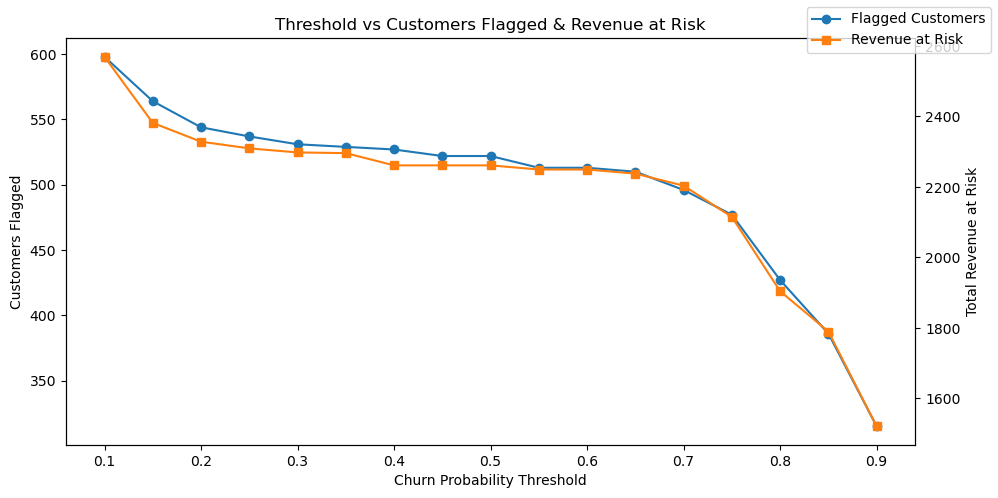

In [19]:
#churn probabilities calc
probs = rf_full.predict_proba(X)[:, 1]  #prob tochurn for each customer

df['ARPU'] = df['Customer Value'] / df['Subscription Length']

thresholds = np.arange(0.1, 0.91, 0.05) #we try diffrent thresholds
customers_flagged = []
revenue_at_risk = []

for thresh in thresholds:
    flagged = probs >= thresh
    customers_flagged.append(flagged.sum())
    revenue_at_risk.append(df.loc[flagged, 'ARPU'].sum())

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(thresholds, customers_flagged, label='Flagged Customers', marker='o')
ax1.set_ylabel('Customers Flagged')
ax1.set_xlabel('Churn Probability Threshold')
ax2 = ax1.twinx()
ax2.plot(thresholds, revenue_at_risk, color='tab:orange', label='Revenue at Risk', marker='s')
ax2.set_ylabel('Total Revenue at Risk')
fig.legend(loc='upper right')
plt.title('Threshold vs Customers Flagged & Revenue at Risk')
plt.tight_layout()
plt.show()

As the churn probability threshold increases (horizontally), fewer customers are flagged as high risk (blue), and the total revenue at risk also declines (orange).   

Moreover, the chart shows that as we raise the threshold, both the number of customers we would target and the revenue at risk go down (both lines are decreasing). At higher thresholds, only the most likely churners are targeted, focusing retention resources on the highest risk group, but leaves some revenue at risk.   

This lets us see how changing the threshold affects both costs and potential savings, helping choose a strategy that fits the company’s priorities.

## Conclusion

In this project I applied various data mining and machine learning methods to predict customer churn in a telecom dataset. Throughout the analysis I identified key factors influencing churn, developed effective predictive models, and provided business insights through simulation. The results demonstrate that data-driven approaches can significantly support customer retention strategies and help telecom companies manage revenue risk more effectively.